In [7]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm

# Transform

In [8]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

transform = transforms.Compose([
	transforms.Resize((224, 224)),  # Works on both PIL and tensor
	transforms.ToTensor(),
	transforms.Normalize(mean, std)  # Works only on tensors, therefor we need to convert the image to tensor beforehand
]) 

In [9]:
BATCH_SIZE = 256

dataset = torchvision.datasets.CIFAR10(root="./cifar10", train=False, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(dataset)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./cifar10
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
           )


In [52]:
def plot_9_imgs_gronud_truth(batch, labels):
	n = 3
	offset = 0  # We can start showing images at some offset untill (offset + n*n)

	fig, ax = plt.subplots(n, n)
	fig.tight_layout()

	for row in range(n):
		for col in range(n):
			cur_ax = ax[row, col]
			img_i = row*n + col + offset

			cur_ax.set_axis_off()
			cur_ax.set_title(str(img_i) + ": " + str(dataset.classes[labels[img_i]]))
			img = batch[img_i].cpu()
			o = img.numpy().transpose(1, 2, 0)
			cur_ax.imshow(o)
	plt.suptitle("Ground truth")

In [55]:
def plot_9_imgs_predictions(images_batch, labels_prediction):
	n = 3
	fig, ax = plt.subplots(n, n)
	fig.tight_layout()

	for row in range(n):
		for col in range(n):
			cur_ax = ax[row, col]
			img_i = row*n + col

			label = classes[labels_prediction.indices[img_i]]

			prob = labels_prediction.values[img_i].item() * 100 # Get probability of the image being of the class
			prob = '%.2f' % prob # Show only 2 decimal places

			title = f"{img_i}: {label} {prob}%"

			cur_ax.set_axis_off()
			cur_ax.set_title(str(title))
			img = images_batch[img_i].cpu()
			o = img.numpy().transpose(1, 2, 0)
			cur_ax.imshow(o)

	plt.suptitle("Predictions")

# ResNet18 - load and change last layer

In [11]:
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.eval()

dataloader_iter = iter(dataloader)
images_batch, labels_batch = dataloader_iter.next()

print("Last layer, before change:", resnet18.fc)  # Out features = 1000

resnet18.fc = nn.Linear(in_features=512, out_features=10)

print("Last layer, after change:", resnet18.fc)  # Notice 3x224x224

print("Image shape after transforms:", images_batch[0].shape) # Notice 3x224x224 after the transformation

Last layer, before change: Linear(in_features=512, out_features=1000, bias=True)
Last layer, after change: Linear(in_features=512, out_features=10, bias=True)
Image shape after transforms: torch.Size([3, 224, 224])


# See how ResNet deals with CIFAR10 images BEFORE TRAINING

This is before any training, just to see how it deals with it!

In [12]:
prediction = resnet18(images_batch)
softmax = nn.Softmax(dim=1)
labels_prediction = torch.max(softmax(prediction), dim=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Text(0.5, 0.98, 'Ground truth')

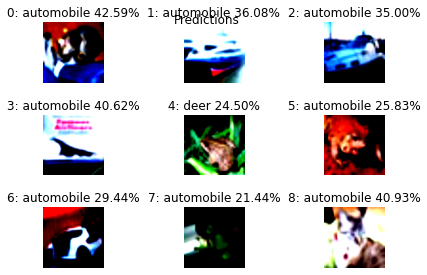

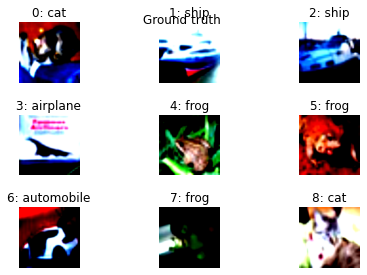

In [13]:
plot_9_predictions(images_batch, labels_batch, labels_prediction)
plot_9_imgs(images_batch, labels_batch)

# GPU

In [14]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print("Using GPU?", torch.cuda.is_available(), device)

torch.cuda.empty_cache()  # I had errors with CUDA taking much of the GPU memory :O

resnet18.to(device);  # If you using CPU, remove this line
# Note to self: Put ';' at the end of the line to disable output print

Using GPU? True cuda:0


# Disable gradients

In [15]:
"""
PyTorch documentation:
https://pytorch.org/docs/stable/notes/autograd.html#setting-requires-grad

Setting requires_grad should be the main way you control which parts of the model are part of the gradient computation, for example, if you need to freeze parts of your pretrained model during model fine-tuning.
To freeze parts of your model, simply apply .requires_grad_(False) to the parameters that you don’t want updated. And as described above, since computations that use these parameters as inputs would not be recorded in the forward pass, they won’t have their .grad fields updated in the backward pass because they won’t be part of the backward graph in the first place, as desired.
"""

# Disable training/learning for the model entirely by setting requires_grad to False
for param in resnet18.parameters():
	param.requires_grad = False

# Only enable the last layer for training by setting requires_grad to True
for param in resnet18.fc.parameters():
	param.requires_grad = True

print("First layer grad: ", next(resnet18.parameters()).requires_grad) # First layer
print("Last layer grad: ", next(resnet18.fc.parameters()).requires_grad) # Last layer

First layer grad:  False
Last layer grad:  True


# Training time!

In [16]:
# Variables
TRAIN_BATCH_SIZE = 256
TEST_BATCH_SIZE = 256
LR = 0.1  # Learning rate
EPOCHS = 5

# Loss function and optimizer
loss_func = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(resnet18.parameters(), lr=LR)

# Accumulators for loss and accuracy
train_loss, train_acc, test_loss, test_acc = [], [], [], []

# Load CIFAR10 datasets for train and test
trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=transform)

# Dataloaders
trainloader = DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=TEST_BATCH_SIZE, shuffle=True)

# Print and check everything is as it should be before training and testing
print("Train set size:", len(trainset))
print("Test set size:", len(testset))
print("Train set classes:", trainset.classes)
print("Test set classes:", testset.classes)

# Print first image shape and class
# Notice: Why is the first image not a cat, as we saw before? Because we use shuffle! And we are using manual_seed(0), so it's OK.
img, label = next(iter(trainset))
print("Image shape:", img.shape)
print("Label:", label, "Class:", trainset.classes[label])

# Print first batch shape
print("Train batch shape:", next(iter(trainloader))[0].shape)
print("Test batch shape:", next(iter(testloader))[0].shape)

classes = trainset.classes

Files already downloaded and verified
Files already downloaded and verified
Train set size: 50000
Test set size: 10000
Train set classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Test set classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Image shape: torch.Size([3, 224, 224])
Label: 6 Class: frog
Train batch shape: torch.Size([256, 3, 224, 224])
Test batch shape: torch.Size([256, 3, 224, 224])


# Define train, test epoch functions

These functions are called once every epoch

They do mini batches

In [19]:
def train_epoch():
    train_loss, train_acc = [], []
    
    for X, y in tqdm(trainloader):
        X = X.float().to(device) # Samples
        y = y.to(device) # Results
        y_hot = nn.functional.one_hot(y, num_classes=len(classes)).float()

        optimizer.zero_grad()
        y_model = resnet18(X) # Model evaluation
        loss = loss_func(y_model,y_hot) # Loss
        train_loss.append(loss.cpu().detach())
        
        predicted_y = y_model.argmax(dim=1)
        acc = (predicted_y == y).sum()/len(y)
        train_acc.append(acc.cpu().detach())
        
        loss.backward()
        optimizer.step()

    return train_loss, train_acc

def test_epoch():
    test_loss, test_acc = [], []

    for X, y in tqdm(testloader):
        X = X.float().to(device) # Samples
        y = y.to(device) # Results
        y_hot = nn.functional.one_hot(y, num_classes=len(classes)).float()

        with torch.no_grad():
            y_model = resnet18(X) # Model evaluation
            loss = loss_func(y_model,y_hot) # Loss
        
        test_loss.append(loss.cpu().detach())
        
        predicted_y = y_model.argmax(dim=1)
        acc = (predicted_y == y).sum()/len(y)
        test_acc.append(acc.cpu().detach())

    return test_loss, test_acc

# Train!

In [20]:
for epoch_i in range(EPOCHS):
	print(f"Epoch {epoch_i+1} train:")
	loss, acc = train_epoch()
	train_loss.extend(loss), train_acc.extend(acc)
    
	print(f"Epoch {epoch_i+1} test:")
	loss, acc = test_epoch() 
	test_loss.extend(loss)
	test_acc.extend(acc)

Epoch 1 train:


100%|██████████| 196/196 [04:11<00:00,  1.28s/it]


Epoch 1 test:


100%|██████████| 40/40 [00:54<00:00,  1.36s/it]


Epoch 2 train:


100%|██████████| 196/196 [05:03<00:00,  1.55s/it]


Epoch 2 test:


100%|██████████| 40/40 [01:01<00:00,  1.54s/it]


Epoch 3 train:


100%|██████████| 196/196 [05:10<00:00,  1.58s/it]


Epoch 3 test:


100%|██████████| 40/40 [01:01<00:00,  1.55s/it]


Epoch 4 train:


100%|██████████| 196/196 [05:09<00:00,  1.58s/it]


Epoch 4 test:


100%|██████████| 40/40 [01:01<00:00,  1.55s/it]


Epoch 5 train:


100%|██████████| 196/196 [03:32<00:00,  1.09s/it]


Epoch 5 test:


100%|██████████| 40/40 [00:50<00:00,  1.27s/it]


# Plot loss and accuracy

Text(0.5, 0, 'Batch Number')

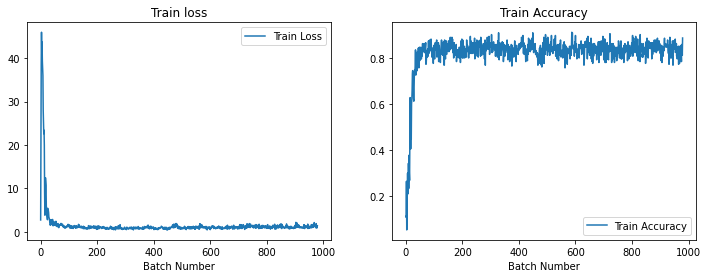

In [34]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_loss, label="Train Loss")
plt.title("Train Loss")
plt.legend()
plt.xlabel("Batch Number")

plt.subplot(1,2,2)
plt.plot(train_acc, label="Train Accuracy")
plt.title("Train Accuracy")
plt.legend()
plt.xlabel("Batch Number")

Text(0.5, 0, 'Batch Number')

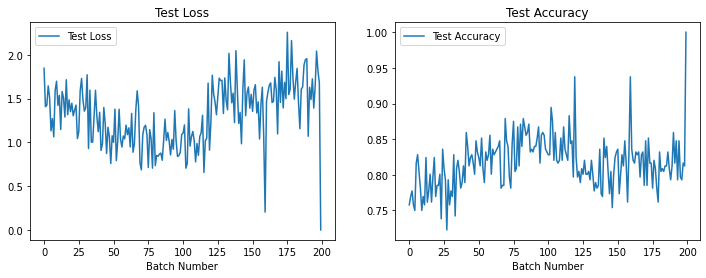

In [35]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(test_loss, label="Test Loss")
plt.title("Test Loss")
plt.legend()
plt.xlabel("Batch Number")

plt.subplot(1,2,2)
plt.plot(test_acc, label="Test Accuracy")
plt.title("Test Accuracy")
plt.legend()
plt.xlabel("Batch Number")

# Plot predictions!

torch.Size([256, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

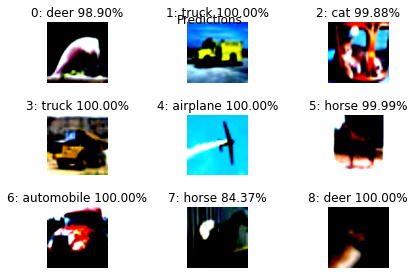

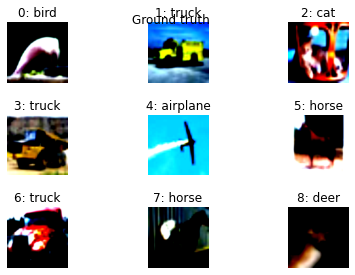

In [57]:
# Get first batch
images_batch, labels_batch = next(iter(testloader))
images_batch = images_batch.float().to(device)

print(images_batch.shape)

# Predict
prediction = resnet18(images_batch)
softmax = nn.Softmax(dim=1)  
labels_prediction = torch.max(softmax(prediction), dim=1)


plot_9_imgs_predictions(images_batch, labels_prediction)
plot_9_imgs_gronud_truth(images_batch, labels_batch)